<a href="https://colab.research.google.com/github/Tahahaha7/Capstone_Project/blob/master/Capstone_Modeling_M2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $$\text{Maximal Covering Location}$$

## $\text{Importing dependencies}$

In [ ]:
%%capture
!pip install -i https://pypi.gurobi.com gurobipy

In [ ]:
# Credit to https://github.com/cyang-kth for compiling the Gurobi solver on Python

import requests
url = 'https://raw.githubusercontent.com/cyang-kth/maximum-coverage-location/master/mclp.py'
r = requests.get(url)

with open('mclp.py', 'w') as f: f.write(r.text)

from mclp import *

----- Configurations -----
  Number of points 300
  K 20
  Radius 0.2
  M 100
Restricted license - for non-production use only - expires 2022-01-13
----- Output -----
  Running time : 0.04046225547790527 seconds
  Optimal coverage points: 218


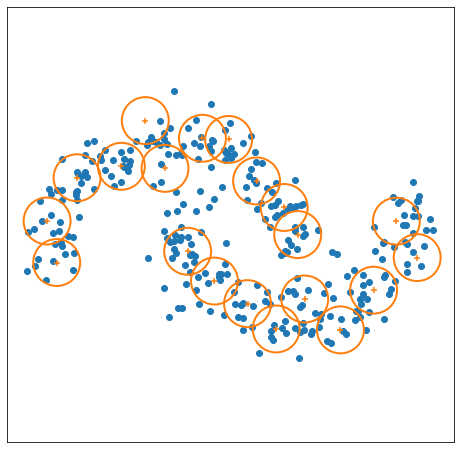

In [ ]:
from mclp import *
import numpy as np

Npoints = 300

from sklearn.datasets import make_moons
points,_ = make_moons(Npoints, noise=0.15)

# Number of sites to select
K = 20

# Service radius of each site
radius = 0.2

# Candidate site size (random sites generated)
M = 100

# Run mclp
# opt_sites is the location of optimal sites 
# f is the number of points covered
opt_sites,f = mclp(points, K, radius, M)

# Plot the result 
plot_result(points, opt_sites, radius)

## $\text{Import the network of London}$

In [ ]:
%%capture
!pip install geopandas

In [ ]:
# Importing packages

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/Capstone

/content/gdrive/My Drive/Capstone


In [ ]:
final_osm_nodes = pd.read_csv('final_osm_nodes.csv')

In [ ]:
uber_osm = pd.read_csv('uber_osm.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
uber_osm['speed_mean_mps'] = uber_osm['speed_mean_mph'].fillna(uber_osm['maxspeed'].astype(int)).values * 0.44704 # from mph to m/s

In [ ]:
uber_osm['mean_travel_time'] = uber_osm.length.values / uber_osm.speed_mean_mps.values

In [ ]:
Graph = nx.from_pandas_edgelist(uber_osm,
                                source='osmid_source', 
                                target='osmid_target', 
                                create_using=nx.MultiDiGraph(), 
                                edge_attr=['name', 'length', 'maxspeed', 'speed_mean_mph',
                                           'pct_from_freeflow', 'speed_freeflow_mph',
                                           'mean_travel_time', 'speed_mean_mps', 
                                           'geometry'])

print(nx.info(Graph))

Name: 
Type: MultiDiGraph
Number of nodes: 126768
Number of edges: 297638
Average in degree:   2.3479
Average out degree:   2.3479


In [ ]:
nx.is_weakly_connected(Graph)

True

In [ ]:
dict_osm = {x: {'position': (a, b), 'imd': c, 'station': (d, dd),
                'population':e, 'children':f, 'elderly':g,
                'men':h, 'women':i, 'women_15_49':j, 'youth':k}
            for x, a, b, c, d, dd, e, f, g, h, i, j, k in zip(final_osm_nodes.osmid, final_osm_nodes.x, 
                                                          final_osm_nodes.y, final_osm_nodes.imd, 
                                                          final_osm_nodes.station, final_osm_nodes.station_name,
                                                          final_osm_nodes.population, 
                                                          final_osm_nodes.children, final_osm_nodes.elderly, 
                                                          final_osm_nodes.men, final_osm_nodes.women, 
                                                          final_osm_nodes.women_15_49, final_osm_nodes.youth)}

nx.set_node_attributes(Graph, dict_osm)

In [ ]:
Graph_copy = Graph.copy()
Graph_copy = nx.relabel_nodes(Graph_copy, dict(zip(Graph_copy.nodes, range(len(Graph_copy.nodes)))))

## $\text{Maximal Covering Location Modeling}$

In [ ]:
imd_data = pd.read_csv('imd_london.csv')
#imd_data = gpd.GeoDataFrame(imd_data, geometry = imd_data.geometry)

----- Configurations -----
  Number of points 1800
  K 150
  Radius 0.005
  M 200
----- Output -----
  Running time : 0.07497072219848633 seconds
  Optimal coverage points: 139


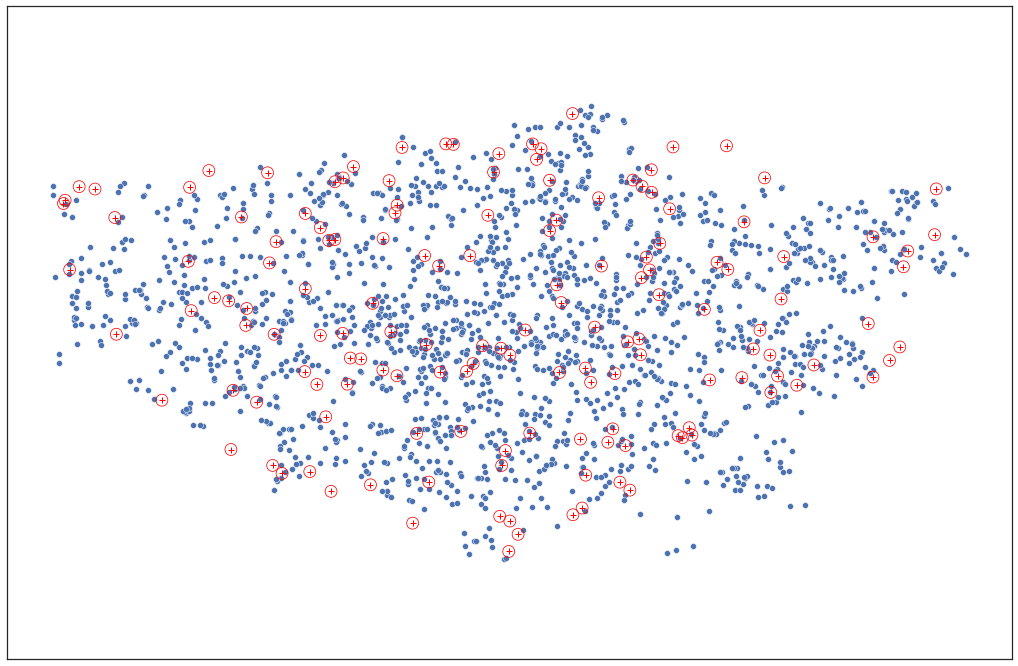

In [ ]:
points = np.array(list(map(list, nx.get_node_attributes(Graph_copy,'position').values())))

points = points[np.random.choice(points.shape[0], size=1800, replace=False), :]

radius = 5*1e-3

opt_sites,f = mclp(points, # demand points
                   150,     # the number of roaming ambulances
                   radius, # the radius of circle 
                   200     # the number of candidate sites
                   )

#plot_result(points, opt_sites, radius)

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("white")

fig = plt.figure(figsize=(18, 12))
sns.scatterplot(x=points[:,0], y=points[:,1], legend=False)#, c='k', s=2)
ax = plt.gca()
plt.scatter(opt_sites[:,0], opt_sites[:,1], c='red', marker='+', lw=1)
for site in opt_sites:
    circle = plt.Circle(site, radius, color='red', fill=False, lw=.75)
    ax.add_artist(circle)
ax.axis('equal')
ax.tick_params(axis='both',left=False, top=False, right=False,
               bottom=False, labelleft=False, labeltop=False,
               labelright=False, labelbottom=False)

In [ ]:
# How scalling up the number of ambulances increases the cover of the area
np.linspace(40, 200, 9)

array([ 40.,  60.,  80., 100., 120., 140., 160., 180., 200.])

In [ ]:
# parameters to tweak:
# radius
# ambulance

points = np.array(list(map(list, nx.get_node_attributes(Graph_copy,'position').values())))
points = points[np.random.choice(points.shape[0], size=1500, replace=False), :]

radius_values = np.linspace(5*1e-3, 5*1e-2, 50)
candidate_values = np.linspace(1.1, 2, 10)
ambulance_values = np.linspace(40, 200, 9)

results_array = []

for radius in radius_values:
    for candidate in candidate_values:
        for ambulance in ambulance_values:
            results_array.append([radius, candidate, ambulance, mclp(points, ambulance, radius, ambulance*candidate)[1]])
    print(radius)

In [ ]:
results3 = pd.DataFrame(results_array, columns=['radius', 'candidate', 'ambulance', 'Coverage'])
#results2 = pd.DataFrame(results_array, columns=['radius', 'candidate', 'ambulance', 'Coverage'])
#results1 = pd.DataFrame(results_array, columns=['radius', 'candidate', 'ambulance', 'Coverage'])

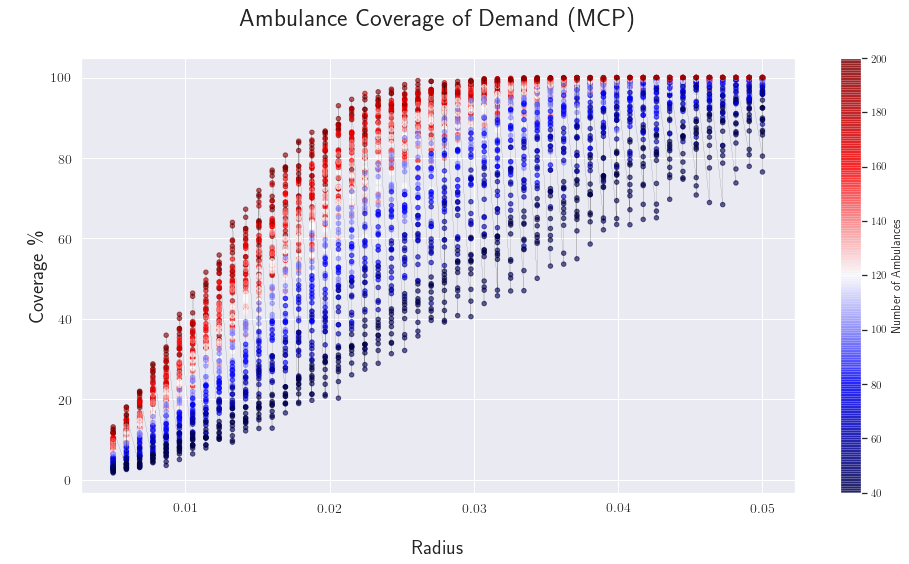

In [ ]:
sns.set()
plt.figure(figsize=(16, 8))
jet=plt.get_cmap('seismic')

results = results3

plt.scatter(results['radius'], round(results['Coverage'] / 15, 2), c= results['ambulance'], s=20, cmap=jet, alpha=.6)
plt.plot(results['radius'], round(results['Coverage'] / 15, 2), linewidth=.1, color='black')
plt.xlabel('\nRadius', fontsize=20); plt.ylabel('\nCoverage \%', fontsize=20); plt.title('Ambulance Coverage of Demand (MCP)\n', fontsize=25)
#plt.title('The change in the Kelly Criterion')
#plt.ylabel('Rate of winning')
#plt.xlabel('Kelly Criterion')
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.colorbar(label='Number of Ambulances')
plt.show()

0         1.67
1         2.87
2         3.47
3         4.87
4         3.73
         ...  
4495    100.00
4496    100.00
4497    100.00
4498    100.00
4499    100.00
Name: Coverage, Length: 4500, dtype: float64

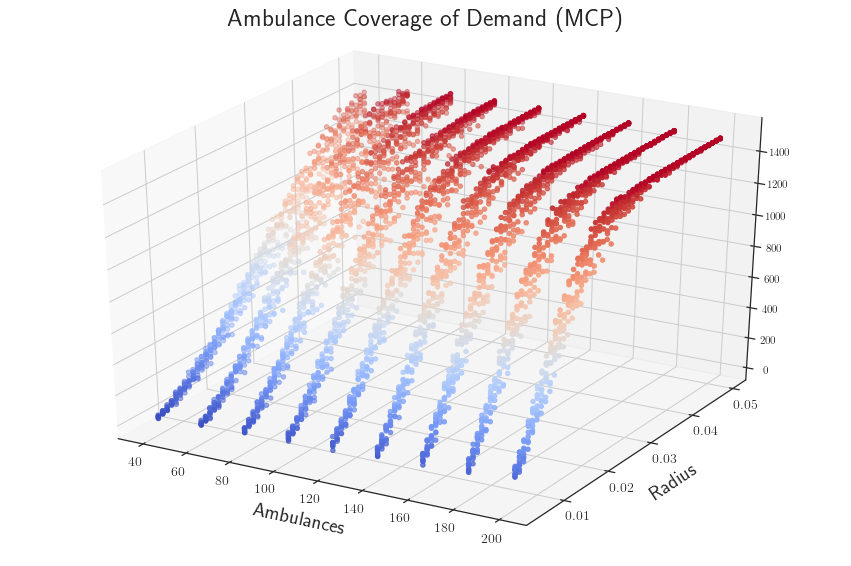

In [ ]:
from mpl_toolkits import mplot3d
sns.set_style("white")
plt.figure(figsize=(15, 10))
ax = plt.axes(projection='3d')
zdata, xdata, ydata = results['Coverage'], results['ambulance'], results['radius']
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='coolwarm')
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlabel('\nAmbulances', fontsize=20); plt.ylabel('\nRadius', fontsize=20); plt.title('Ambulance Coverage of Demand (MCP)\n', fontsize=25)
plt.show()

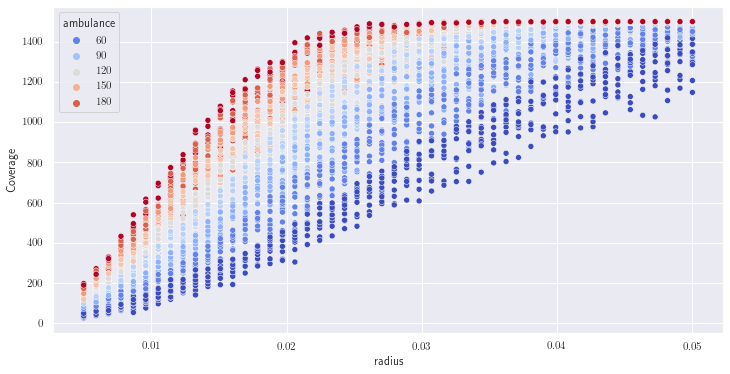

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(y="Coverage", x="radius", data=results, hue="ambulance", palette='coolwarm');

In [ ]:
np.linspace(5*1e-3, 4*1e-2, 10)

array([0.005     , 0.00888889, 0.01277778, 0.01666667, 0.02055556,
       0.02444444, 0.02833333, 0.03222222, 0.03611111, 0.04      ])

In [ ]:
points = np.array(list(map(list, nx.get_node_attributes(Graph_copy,'position').values())))

points = points[np.random.choice(points.shape[0], size=1800, replace=False), :]

radius = np.linspace(1e-2, 4*1e-2, 10)#np.linspace(5*1e-3, 1e-2, 10)

store = []

for r in radius :
    store.append(mclp(points, 50, r, 200))

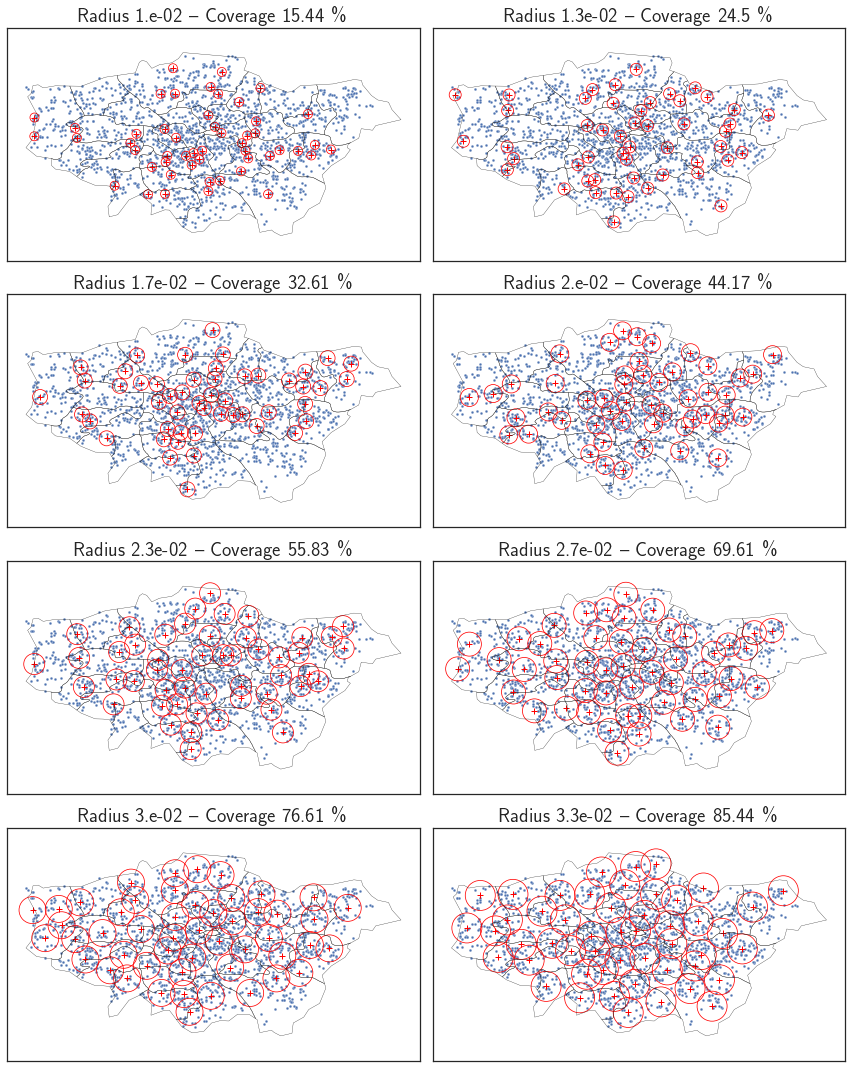

In [ ]:
plt.figure(figsize=(12, 15))

for idx,i in enumerate(store[:8]):
    plt.subplot(4, 2, idx+1)
    plt.title('Radius {} -- Coverage {} \%'.format(np.format_float_scientific(round(radius[idx], 3)), round(i[1]/18, 2)), fontsize=20)
    sns.scatterplot(x=points[:,0], y=points[:,1], legend=False, s=7)#, c='k', s=2)
    ax = plt.gca()
    imd_data.boundary.plot(ax=ax, lw=.3, color='k')
    plt.scatter(i[0][:,0], i[0][:,1], c='red', marker='+', lw=1)
    for site in i[0]:
        circle = plt.Circle(site, radius[idx], color='red', fill=False, lw=.75)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                  bottom=False, labelleft=False, labeltop=False,
                  labelright=False, labelbottom=False)
plt.tight_layout()

In [ ]:
from shapely import wkt

#final_osm_nodes = gpd.read_file('final_osm_nodes.gpkg', driver='GPKG')
imd_data = pd.read_csv('imd_london.csv')
imd_data['geometry'] = imd_data['geometry'].apply(wkt.loads)

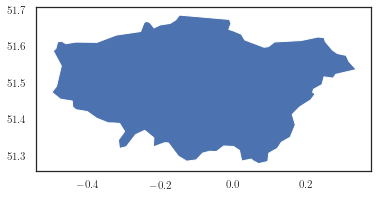

In [ ]:
from shapely.ops import cascaded_union

boundary = gpd.GeoSeries(cascaded_union(imd_data['geometry']))
boundary.plot()
plt.show()

In [ ]:
imd_data = gpd.GeoDataFrame(imd_data, geometry='geometry')

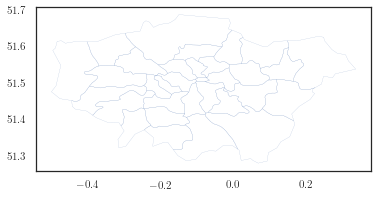

In [ ]:
imd_data.boundary.plot(lw=.2)

## $\text{Rendering to Latex}$

In [ ]:
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
%matplotlib inline

rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

In [ ]:
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8